# Sprint 機械学習スクラッチ ロジスティック回帰

## 1.このSprintについて
<u>Sprintの目的</u>  
・スクラッチを通してロジスティック回帰を理解する
・分類問題についての基礎を学ぶ 

<u>どのように学ぶか</u>  
スクラッチでロジスティック回帰を実装した後、学習と検証を行なっていきます。

## 2.ロジスティック回帰スクラッチ
ロジスティック回帰のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


以下に雛形を用意してあります。このScratchLogisticRegressionクラスにコードを書き加えていってください。推定関係のメソッドは線形回帰と異なり、ラベルを出力するpredictメソッドと、確率を出力するpredict_probaメソッドの2種類を作成します。

## ＜データ読込＞

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

# アヤメセットを読み込む
iris_data = load_iris()

# 説明変数
df_X = pd.DataFrame(iris_data.data, columns=["sepal_length", "sepal_width", "petal_length", "petal_width"])


# 目的変数
df_y = pd.DataFrame(iris_data.target, columns=["species"])

df = pd.concat([df_X, df_y], axis=1)

data_X = df.iloc[:,0:4][df["species"] != 0]
data_y = df.iloc[:,4][df["species"] != 0]

X = np.array(data_X)
y = np.array(data_y).reshape(-1,1)

ds_iris={}

# 特徴量は２つに絞る
X = X[:,0:2]
y = y -1

ds_iris["X"] = X
ds_iris["y"] = y

# 訓練データと検証データの分割
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25)


scaler = StandardScaler()
scaler.fit(X_train)
ss_X_train = scaler.transform(X_train)
ss_X_val = scaler.transform(X_val)

In [6]:
class ScratchLogisticRegression():
    """
    ロジスティック回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      訓練データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証データに対する損失の記録

    """
    def __init__(self, num_iter, lr, lamb = 5, no_bias= False, verbose = True):
        np.set_printoptions(precision=8, suppress=True)
        
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.no_bias = no_bias
        self.verbose = verbose
        self.lamb = lamb
        
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ロジスティック回帰を学習する。検証データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        val_cnt =0
        
        y = y.reshape(-1,1)
        
        
        # 学習データと検証データの比率を出す
        if X_val is not None:
            y_val = y_val.reshape(-1,1)
            val_rate = int( X.shape[0] / X_val.shape[0])
        
        # 学習開始        
        # 初期値設定    
        
        # ＜Θの初期値を決定するため、バイアスの有無でＸのshapeを決定＞
        # バイアスありの場合
        if self.no_bias == False:
            # バイアス項 算出
            baias = np.ones(X.shape[0]).reshape(X.shape[0],1)
            
            # バイアス追加
            bias_X = np.hstack([baias, X])
            
            if X_val is not None:
                baias = np.ones(X_val.shape[0]).reshape(X_val.shape[0],1)
                bias_X_val = np.hstack([baias, X_val])
    
        # XのshapeによってΘの要素数を決定
        self.theta = np.random.rand(bias_X.shape[1]).reshape(-1,1)
        self.coef_ = self.theta

        for i in range(self.iter):
            # 推定(1or2を予想するので＋1を印加する)
            y_pred_proba = self.predict_proba(X) 
            if i%200 == 0:
                print("iter = {}".format(i))
                print("y_pred_proba = \n{}".format(y_pred_proba))

            # 誤差
            self.loss[i] = self.loss_func(y_pred_proba, y)

            # 最急降下法
            error = y_pred_proba - y
            self.coef_ = self._gradient_descent(bias_X, error)
                
            if self.verbose:
                #verboseをTrueにした際は学習過程を出力
                if i%200 == 0:
                    print("〇〇〇学習データ{}回目：loss = {}".format(i+1, self.loss[i]))
              
            # 検証データがセットされた場合
            if X_val is not None:
                
                # 推定
                y_val_pred_proba = self.predict_proba(X_val)

                # ロス関数
                self.val_loss[i] = self.loss_func(y_val_pred_proba, y_val)

                if self.verbose:
                    #verboseをTrueにした際は学習過程を出力
                    if i%200 == 0:
                        print("★★★検証データ{}回目：loss = {}".format(val_cnt, self.val_loss[i]))

                val_cnt += 1
                
                #return self.coef_

    def predict(self, X):
        """
        ロジスティック回帰を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        
        y_pred_proba = self.predict_proba(X)
        threshold = 0.5
        y_pred = np.floor(y_pred_proba + threshold)
        
        return y_pred
    
    def predict_proba(self, X):
        """
        ロジスティック回帰を使い確率を推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        if self.no_bias == False:
            # バイアス項 算出
            baias = np.ones(X.shape[0]).reshape(X.shape[0],1)
            
            # バイアス追加
            bias_X = np.hstack([baias, X])  
            
        else:
            bias_X = X

        y_pred_proba = self._hypothesis_func(bias_X)
        
        return y_pred_proba
    
    # シグモイド関数（ロジスティック関数）
    def sigmoid(X):
        z = np.dot(X, self.theta)
        return 1/(1 + np.exp(-z))    
    
    # 【問題1】仮定関数
    def _hypothesis_func(self, X):
        """
        線形の仮定関数を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ

        Returns
        -------
          次の形のndarray, shape (n_samples, 1)
          線形の仮定関数による推定結果

        """
        # 特徴量ベクトル:X
        # パラメータベクトル:乱数生成
        # 特徴量の数:X.shape[1]
        
        # 線形回帰の仮定関数
        z = np.dot(X, self.theta)
        
        # シグモイド関数
        hypothesis = 1/(1 + np.exp(-z))  
        
        return hypothesis

    
    # 【問題2】最急降下法
    def _gradient_descent(self, X, error):
        """
        最急降下法を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ
        error : 計算した誤差

        Returns
        -------
          次の形のndarray, shape (n_samples, 1)
          線形の仮定関数による推定結果

        """
              
        # バイアスありの場合
        if self.no_bias == False:
            # ＮＧルート
            if True:
                # j = 0 の場合
                self.theta[0] = self.theta[0] - (self.lr / X.shape[0]) * (np.dot(X[:,0].T, error))  

                # j ≧ 1 の場合
                self.theta[1:] = self.theta[1:] - self.lr * ( ((1/ X.shape[0]) * np.dot(X[:,1:].T, error)) + \
                (self.lamb/X.shape[0]) * self.theta[1:] ) 
            
            '''
            # 別解
            else:
                # 全領域に正則化以外の項を適用
                self.theta = self.theta - (self.lr / X.shape[0]) * (np.dot(X.T, error)) 
                
                # J ≧ 1 の項に正則化項を適用
                self.theta[1:] = self.theta[1:] - self.lr *( (self.lamb/X.shape[0]) * self.theta[1:] )
            '''
            
            
        # バイアス無しの場合
        else:
            self.theta = self.theta - (self.lr / X.shape[0]) * (np.dot(X.T, error)) + (self.lamb/X.shape[0]) * self.theta 
            
        return self.theta
    
    
    def loss_func(self, y_pred_proba, y):
            
        loss = (((-np.log(y_pred_proba)*y)) \
                + (-np.log(1-y_pred_proba)*(1-y))).mean() / X.shape[1]  \
                + self.lamb / (2 * X.shape[1]) * sum(self.theta**2)
            
        return loss    
    

## 【問題1】仮定関数
ロジスティック回帰の仮定関数のメソッドをScratchLogisticRegressionクラスに実装してください。


ロジスティック回帰の仮定関数は、線形回帰の仮定関数を シグモイド関数 に通したものです。シグモイド関数は以下の式で表されます。


$
g(z) = \frac{1}{1+e^{−z}}
$

線形回帰の仮定関数は次の式でした。


$
h_\theta(x) = \theta^T \cdot x
$

まとめて書くと、ロジスティック回帰の仮定関数は次のようになります。

$
h_\theta(x) = \frac{1}{1+e^{−\theta^T \cdot x}}.
$

$x$ : 特徴量ベクトル


$θ$ : パラメータ（重み）ベクトル

```python
    # 線形回帰の仮定関数
    z = np.dot(X, self.theta)

    # シグモイド関数
    hypothesis = 1/(1 + np.exp(-z))  
```

## 【問題2】最急降下法
最急降下法により学習させる実装を行なってください。以下の式で表されるパラメータの更新式のメソッド_gradient_descentを追加し、fitメソッドから呼び出すようにしてください。

$$
\theta_j := \theta_j - \alpha \frac{\partial J(\theta)}{\partial \theta_j}------①\\
\frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m}  \sum_{i=1}^{m}(h_θ(x^{(i)}) − y^{(i)})x_j^{(i)}   ,j = 0　--------②\\
\frac{\partial J(\theta)}{\partial \theta_j} = \biggl(\frac{1}{m}  \sum_{i=1}^{m}(h_θ(x^{(i)}) − y^{(i)})x_j^{(i)} \biggr) + \frac{λ}{m}\theta_j　  ,j\geq 1---------③\\
\theta_0 := \theta_0 - \alpha \frac{1}{m}  \sum_{i=1}^{m}(h_θ(x^{(i)}) − y^{(i)})x_0^{(i)}　  ,j = 0\\
\theta_j := \theta_j - \alpha \biggl(\frac{1}{m}  \sum_{i=1}^{m}(h_θ(x^{(i)}) − y^{(i)})x_j^{(i)} \biggr) + \frac{λ}{m}\theta_j　  ,j\geq 1\\
$$


$\alpha$ : 学習率


$i$ : サンプルのインデックス


$j$ : 特徴量のインデックス


$m$ : 入力されるデータの数


$h_\theta()$ : 仮定関数


$x$ : 特徴量ベクトル


$\theta$ : パラメータ（重み）ベクトル


$x^{(i)}$ : i番目のサンプルの特徴量ベクトル


$y^{(i)}$ : i番目のサンプルの正解ラベル


$\theta_j$ : j番目のパラメータ（重み）


$λ$ : 正則化パラメータ




## 【問題3】推定
推定する仕組みを実装してください。ScratchLogisticRegressionクラスの雛形に含まれるpredictメソッドとpredict_probaメソッドに書き加えてください。


仮定関数 $h_\theta(x)$ の出力がpredict_probaの返り値、さらにその値に閾値を設けて1と0のラベルとしたものがpredictの返り値となります。

class ScratchLogisticRegression に実装
```python
    def predict_proba(self, X):
        """
        ロジスティック回帰を使い確率を推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        y_pred_proba = self._hypothesis_func(X)
        
        return y_pred_proba
```

```python
    def predict(self, X):
        """
        ロジスティック回帰を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        threshold = 0.5
        y_pred_proba = self._hypothesis_func(X)
        y_pred = np.floor(y_pred_proba + threshold)
        return y_pred
```

## 【問題4】目的関数
以下の数式で表されるロジスティック回帰の 目的関数（損失関数） を実装してください。そして、これをself.loss, self.val_lossに記録するようにしてください。


なお、この数式には正則化項が含まれています。


＊数式が見切れる場合、DIVERを全画面にして御覧ください。

$
J(\theta)=  \frac{1}{m}  \sum_{i=1}^{m}[−y^{(i)} log(h_θ(x^{(i)})) − (1−y^{(i)}) log(1−h_θ(x^{(i)}))] +
\frac{λ}{2m}\sum_{j=1}^n
θ^2_j.\\
$

$m$ : 入力されるデータの数


$h_\theta()$ : 仮定関数


$x$ : 特徴量ベクトル


$\theta$ : パラメータ（重み）ベクトル


$x^{(i)}$ : i番目のサンプルの特徴量ベクトル


$y^{(i)}$ : i番目のサンプルの正解ラベル


$\theta_j$ : j番目のパラメータ（重み）


$n$ : 特徴量の数


$λ$ : 正則化パラメータ

$$
J(\theta)=  \frac{1}{m}  \sum_{i=1}^{m}[−y^{(i)} log(h_θ(x^{(i)})) − (1−y^{(i)}) log(1−h_θ(x^{(i)}))] +
\frac{λ}{2m}\sum_{j=1}^n
θ^2_j.\\
$$

```python
    def loss_func(self, y_pred, y):
        
        #loss  = MSE(y_pred, y) / 2
        loss = (1/y_pred.shape[0]) * ((-y * np.log(y_pred)) - (1 - y) * np.log(1-y_pred)) + \
            (self.lamb/(2 * y_pred.shape[0])) * np.square(self.theta)
        
        return loss  
```

## 3.検証

## 【問題5】学習と推定

In [7]:
ScratchLR = ScratchLogisticRegression(num_iter = 1000, lr = 0.08, lamb = 0, no_bias = False, verbose = True)

# 学習開始
clf = ScratchLR.fit(ss_X_train, y_train, ss_X_val, y_val)


iter = 0
y_pred_proba = 
[[0.39179341]
 [0.35072208]
 [0.67809635]
 [0.36701741]
 [0.83370291]
 [0.44862448]
 [0.91746047]
 [0.6318633 ]
 [0.51351167]
 [0.40371788]
 [0.57794659]
 [0.38180795]
 [0.57981901]
 [0.52402182]
 [0.50298955]
 [0.71527106]
 [0.55208434]
 [0.30725067]
 [0.40879552]
 [0.60522496]
 [0.47477737]
 [0.76657909]
 [0.85764531]
 [0.48528556]
 [0.58493879]
 [0.46761843]
 [0.64336539]
 [0.54687324]
 [0.93561376]
 [0.44862448]
 [0.61206858]
 [0.17872168]
 [0.3364803 ]
 [0.65296606]
 [0.51876882]
 [0.40879552]
 [0.30116931]
 [0.61206858]
 [0.56436052]
 [0.71096454]
 [0.35553061]
 [0.84329269]
 [0.49054513]
 [0.82778357]
 [0.61705493]
 [0.45715302]
 [0.60522496]
 [0.20604282]
 [0.84505142]
 [0.7931684 ]
 [0.56436052]
 [0.30278834]
 [0.62695319]
 [0.16563061]
 [0.61024327]
 [0.34594368]
 [0.37192137]
 [0.1627419 ]
 [0.68267401]
 [0.29836291]
 [0.51159266]
 [0.89620239]
 [0.71096454]
 [0.74576661]
 [0.40879552]
 [0.77032465]
 [0.66244387]
 [0.8078367 ]
 [0.60705864]
 [0.38678

In [4]:
import pandas as pd
from sklearn.metrics import classification_report

y_pred_proba = ScratchLR.predict(ss_X_val)
print("ss_X_val.shape = {}".format(ss_X_val.shape))
print("y_pred_proba.shape = {}".format(y_pred_proba.shape))
target_names = [iris_data.target_names[1], iris_data.target_names[2]]
cr = classification_report(y_val.flatten(), y_pred_proba.flatten(), target_names = target_names, output_dict=True)
#print(cr)

# pandas.DataFrameへ変換
df_cr = pd.DataFrame(cr)
df_cr

bias_X.shape = (25, 3)
X.shape = (25, 3)
ss_X_val.shape = (25, 2)
y_pred_proba.shape = (25, 1)


,versicolor,virginica,accuracy,macro avg,weighted avg
precision,0.625000,0.666667,0.64,0.645833,0.645000
recall,0.769231,0.500000,0.64,0.634615,0.640000
f1-score,0.689655,0.571429,0.64,0.630542,0.632906
support,13.000000,12.000000,0.64,25.000000,25.000000


## 【問題6】学習曲線のプロット

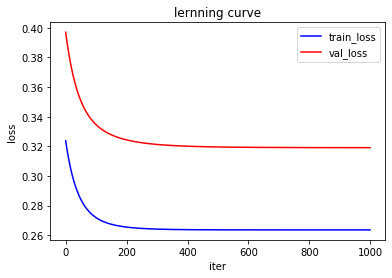

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(ScratchLR.loss)), ScratchLR.loss, color='blue', label='train_loss')
plt.plot(range(len(ScratchLR.val_loss)), ScratchLR.val_loss, color='red', label='val_loss')
plt.xlabel("iter")
plt.ylabel("loss")
plt.title("lernning curve")
plt.legend()
plt.show()

## 【問題7】決定領域の可視化

In [6]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    print("<<decision_region>>")
    
    print("X.shape = {}".format(X.shape))
    print("X.shape = {}".format(y.shape))
    
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), \
                                    np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    print("mesh.shape = {}".format(mesh.shape))
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], \
                    label=target_names[i], marker='o')
        
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

<<decision_region>>
X.shape = (75, 2)
X.shape = (75,)
mesh.shape = (343440, 2)
bias_X.shape = (343440, 3)
X.shape = (343440, 3)


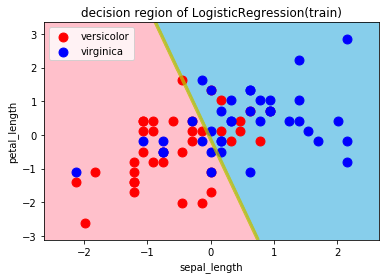

In [7]:
# 可視化
decision_region(ss_X_train, y_train.flatten(), ScratchLR, title='decision region of LogisticRegression(train)', xlabel='sepal_length', ylabel='petal_length')

<<decision_region>>
X.shape = (25, 2)
X.shape = (25,)
mesh.shape = (319915, 2)
bias_X.shape = (319915, 3)
X.shape = (319915, 3)


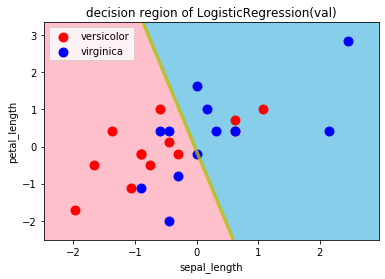

In [8]:
# 可視化
decision_region(ss_X_val, y_val.flatten(), ScratchLR, title='decision region of LogisticRegression(val)', xlabel='sepal_length', ylabel='petal_length')

### sklearnと比較

C:\Users\Takatoshi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,versicolor,virginica,accuracy,macro avg,weighted avg
precision,0.625000,0.666667,0.64,0.645833,0.645000
recall,0.769231,0.500000,0.64,0.634615,0.640000
f1-score,0.689655,0.571429,0.64,0.630542,0.632906
support,13.000000,12.000000,0.64,25.000000,25.000000


<<decision_region>>
X.shape = (75, 2)
X.shape = (75,)
mesh.shape = (343440, 2)


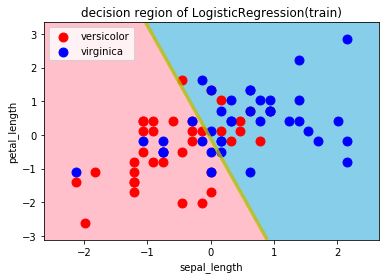

In [9]:
from sklearn.linear_model import LogisticRegression
# 学習
model_LR = LogisticRegression()
clf = model_LR.fit(ss_X_train, y_train)

# 推定
y_pred_LR = model_LR.predict(ss_X_val)

# 評価
target_names = [iris_data.target_names[1], iris_data.target_names[2]]
cr_LR = classification_report(y_val, y_pred_LR, target_names = target_names, output_dict=True)

# pandas.DataFrameへ変換
df_cr_LR = pd.DataFrame(cr_LR)
display(df_cr_LR)

# 可視化
decision_region(ss_X_train, y_train.flatten(), clf, title='decision region of LogisticRegression(train)', xlabel='sepal_length', ylabel='petal_length')

<<decision_region>>
X.shape = (25, 2)
X.shape = (25,)
mesh.shape = (319915, 2)


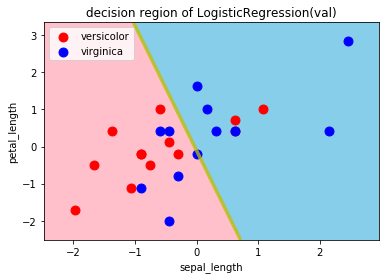

In [10]:
# 可視化
decision_region(ss_X_val, y_val.flatten(), clf, title='decision region of LogisticRegression(val)', xlabel='sepal_length', ylabel='petal_length')

## 【問題8】（アドバンス課題）重みの保存

### ScratchLR.coef_の書込み

In [11]:
import pickle
print("coef_ =\n{}".format(ScratchLR.coef_))
with open('sprint4_coef.pkl', 'wb') as pkl:
    pickle.dump(ScratchLR.coef_, pkl)

coef_ =
[[0.03766981]
 [1.28693366]
 [0.32234128]]


### ScratchLR.coef_の読込み

In [12]:
with open('sprint4_coef.pkl', 'rb') as pkl:
    # 別変数にロード
    load_test = pickle.load(pkl)
    print("coef_ =\n{}".format(load_test))


coef_ =
[[0.03766981]
 [1.28693366]
 [0.32234128]]


### np.savezを使ってみる

In [17]:
np.savez('sprint4_coef.npz', coef = ScratchLR.coef_)

In [18]:
npz = np.load('sprint4_coef.npz')

In [19]:
print(npz.files)

['coef']
